## import

In [1]:
from src.config.config import Config
from src.db_writer.db import DB
from src.quarter_functions import get_delivery, get_quarter_time_left, get_quarter_symbol

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (12.8, 7.2)


from tqdm import tqdm
from IPython.display import clear_output

In [2]:
config = Config()
db = DB(config)

## load data

### load from DB

In [3]:
# # BTC_current_quarter = pd.read_sql('SELECT * FROM `exchange data`.BTC_current_quarter;', con=db.con)
# # BTC_current_quarter.to_csv(f'{config.files_location}/SQLdata/BTC_current_quarter.csv')
# # print('-- ', end=' ')

# # BTC_perpetual = pd.read_sql('SELECT * FROM `exchange data`.BTC_perpetual;', con=db.con)
# # BTC_perpetual.to_csv(f'{config.files_location}/SQLdata/BTC_perpetual.csv')
# # print('-- ', end=' ')

# BTC_cq_bid_ask = pd.read_sql('SELECT * FROM `exchange data`.BTC_cq_bid_ask;', con=db.con)
# BTC_cq_bid_ask.to_csv(f'{config.files_location}/SQLdata/BTC_cq_bid_ask.csv')
# print('-- ', end=' ')

# BTC_perp_bid_ask = pd.read_sql('SELECT * FROM `exchange data`.BTC_perp_bid_ask;', con=db.con)
# BTC_perp_bid_ask.to_csv(f'{config.files_location}/SQLdata/BTC_perp_bid_ask.csv')
# print('-- ', end=' ')

In [4]:
BTC_cq_bid_ask = pd.read_csv(f"{config.files_location}/SQLdata/BTC_perpetual.csv")
BTC_perp_bid_ask = pd.read_csv(f"{config.files_location}/SQLdata/BTC_perp_bid_ask.csv")

## load from Binance

In [5]:
BTC_cq_bid_ask['timestamp'].min(), BTC_cq_bid_ask['timestamp'].max()
# (1661248680, 1691568120)

(1567965420, 1691568120)

In [6]:
def preprocess_data(data, symbol):
    data_preprocessed = pd.DataFrame([[row[i] for i in [0,1,4,3,2,5,8]] for row in data], 
                columns=['timestamp', 'open', 'close', 'low', 'high', 'volume', 'trades'])
    data_preprocessed['timestamp']/=1000
    data_preprocessed.insert(column='symbol', loc=1, value=symbol)
    return data_preprocessed

In [13]:
from src.send_telegram_message import send_telegram_message
from time import sleep

In [17]:
def load_historical_perentrentual_data_batches(start_time, end_time):
    all_time_data = []
    endTime = (end_time + 30) * 1000
    i=0
    while endTime > start_time * 1000:
        try:
            all_time_data += config.binance_client.futures_klines(
                        symbol = config.symbol, 
                        interval = '1m', 
                        limit = 1500, 
                        endTime = endTime)
            i+=1
            print(f"{i}/337")
            clear_output(wait=True)
            endTime -= 90000000
        except:
            send_telegram_message('err', config.tg_chat_id, config.tg_daiy_token)
            sleep(30)



    return preprocess_data(all_time_data, 'BTCUSDT')        


def load_historical_quarterly_data_batches(start_time, end_time, num_batches=120):
    final_data = pd.DataFrame()
    endTime = (end_time + 30) * 1000
    symbol = get_quarter_symbol(config.symbol,endTime/1000)
    finished_trigger = False
    quarter_data = []
    while endTime > start_time * 1000:
        try:
            for i in range(num_batches):
                data_1500 = config.binance_client.futures_klines(
                                symbol = symbol, 
                                interval = '1m', 
                                limit = 1500, 
                                endTime = endTime)
                quarter_data += data_1500
                endTime -= 90000000
                
                if(len(data_1500) < 1500):
                    finished_trigger = True
                    break

            if(finished_trigger == True):
                final_data = pd.concat([final_data, preprocess_data(quarter_data, symbol)])
                quarter_data = []
                print(f"quarter {symbol} loading finished successfully")
                symbol = get_quarter_symbol(config.symbol,endTime//1000)
                endTime = get_delivery(endTime//1000)*1000
                # print(f"{symbol} quarter endTime is {endTime}")
                finished_trigger = False
                print(f"quarter {symbol} loading")
            else:
                final_data = pd.concat([final_data, preprocess_data(quarter_data, symbol)])
                print(symbol, end=' ')  
        except:
            send_telegram_message('err', config.tg_chat_id, config.tg_daiy_token)
            sleep(30) 
    print(symbol)
    return final_data 

In [16]:
BTC_perpetual = load_historical_perentrentual_data_batches(
    BTC_perp_bid_ask['timestamp'].min(), 
    BTC_perp_bid_ask['timestamp'].max()
)
BTC_perpetual.to_csv(f'{config.files_location}/binance_data/load_historical_perentrentual_data_batches.csv')

337/337


In [19]:
# BTC_current_quarter = load_historical_quarterly_data_batches(
#     BTC_perp_bid_ask['timestamp'].min(), 
#     BTC_perp_bid_ask['timestamp'].max()
# )
# BTC_current_quarter.to_csv(f'{config.files_location}/binance_data/load_historical_quarterly_data_batches.csv')

quarter BTCUSDT_230929 loading finished successfully
quarter BTCUSDT_230630 loading
quarter BTCUSDT_230630 loading finished successfully
quarter BTCUSDT_230331 loading
quarter BTCUSDT_230331 loading finished successfully
quarter BTCUSDT_221230 loading
quarter BTCUSDT_221230 loading finished successfully
quarter BTCUSDT_220930 loading
quarter BTCUSDT_220930 loading finished successfully
quarter BTCUSDT_220624 loading
BTCUSDT_220624


### load rest

In [22]:
BTC_current_quarter = pd.read_csv(f'{config.files_location}/binance_data/load_historical_quarterly_data_batches.csv', index_col=[0])
BTC_perpetual = pd.read_csv(f'{config.files_location}/binance_data/load_historical_perentrentual_data_batches.csv', index_col=[0])
BTC_cq_bid_ask = pd.read_csv(f'{config.files_location}/SQLdata/BTC_cq_bid_ask.csv', index_col=[0])
BTC_perp_bid_ask = pd.read_csv(f'{config.files_location}/SQLdata/BTC_perp_bid_ask.csv', index_col=[0])

In [30]:
BTC_current_quarter = BTC_current_quarter\
            .sort_values(['timestamp', 'symbol'])\
            .drop_duplicates(subset=['timestamp'], keep='first')\
            .reset_index(drop=True)

BTC_perpetual.sort_values('timestamp', inplace=True)

### merge

In [31]:
candles = BTC_perpetual.merge(
            BTC_current_quarter, 
            on='timestamp', 
            how='left', 
            suffixes=['_perp', '_cq'])

order_book = BTC_perp_bid_ask.merge(
            BTC_cq_bid_ask, 
            on='timestamp', 
            suffixes=['_perp', '_cq'])


candles = candles[candles['timestamp'] >= order_book['timestamp'].min()]


df_total = candles.merge(
            order_book, 
            on='timestamp',
            how='left')

In [33]:
df_total['timestamp'] = df_total['timestamp'].astype(int)
df_total['time_left'] = df_total['timestamp'].apply(get_quarter_time_left)

In [34]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


### funding rate restoration

### Fill missing

In [35]:
df_total = df_total.interpolate()

## EDA

In [36]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


### time_left

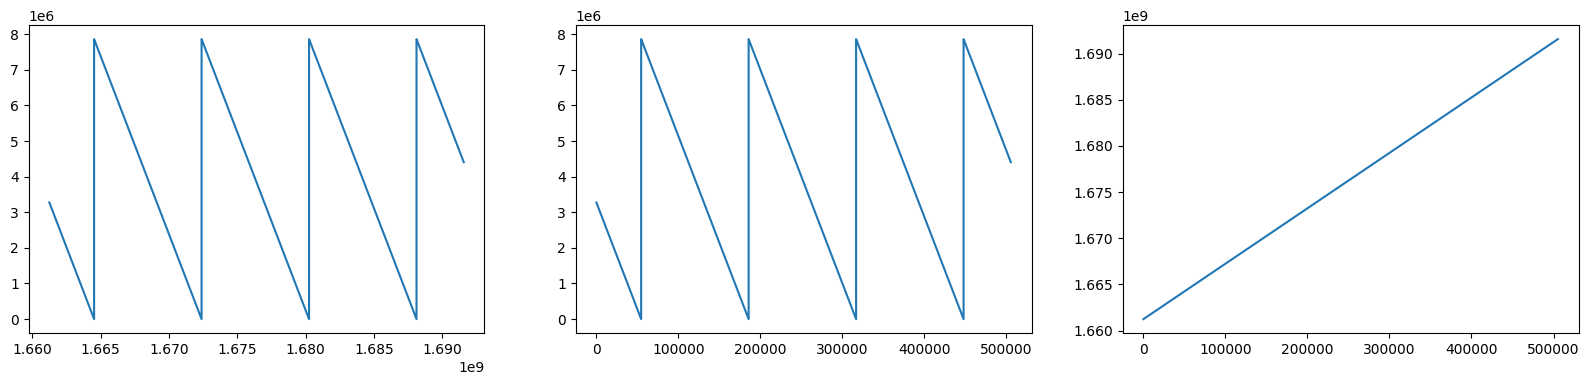

In [37]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(20, 4))
ax1.plot(df_total['timestamp'], df_total['time_left'])
ax2.plot(df_total['time_left'])
ax3.plot(df_total['timestamp'])
plt.show()

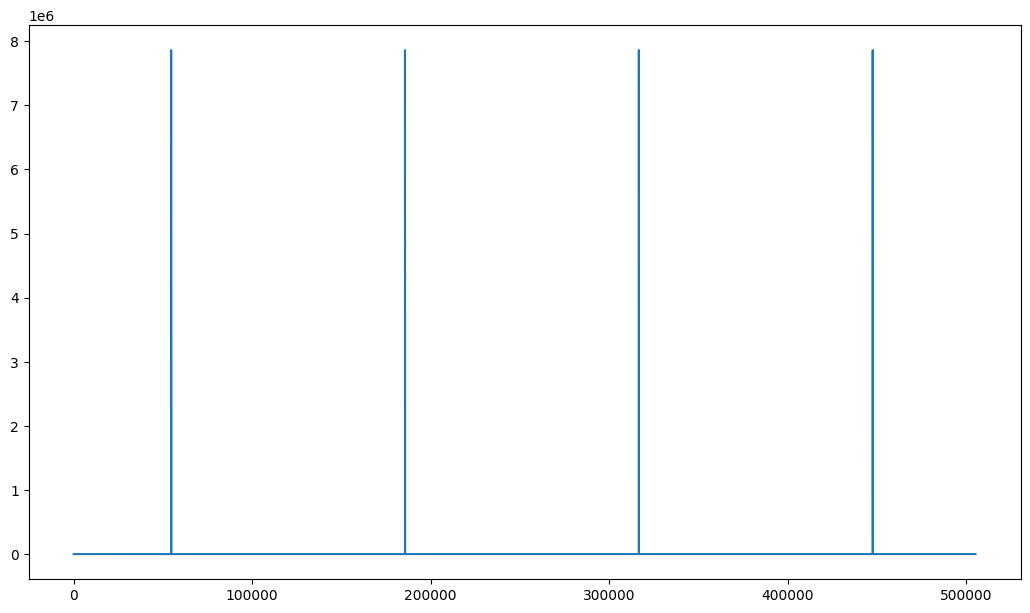

In [38]:
plt.figure(figsize=(12.8, 7.2))
temp = df_total['time_left'].diff()
plt.plot(temp)

(0.0, 32000.0)

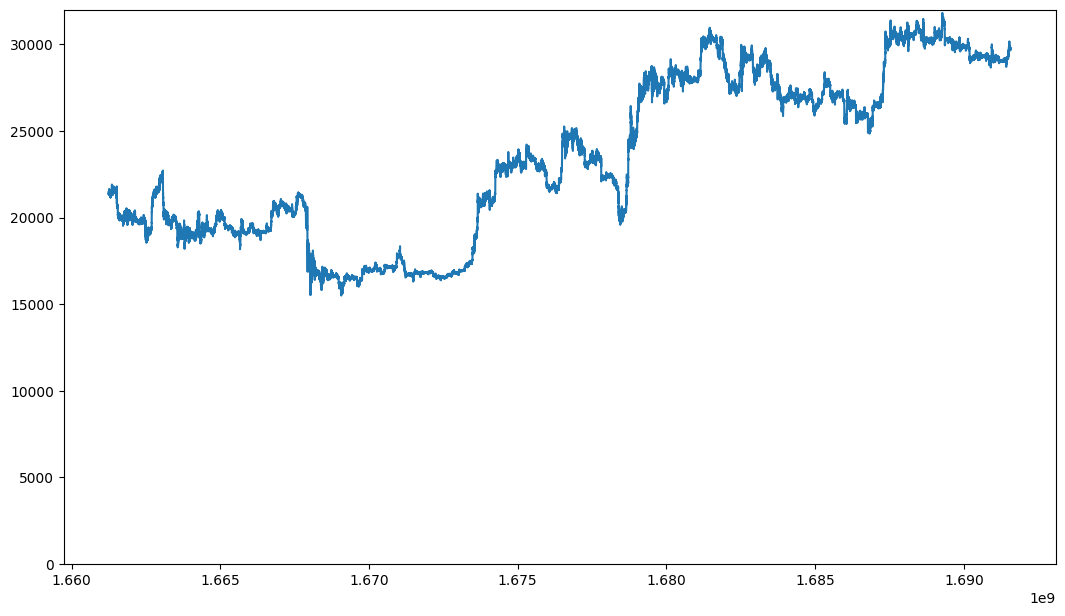

In [39]:
plt.figure(figsize = (12.8, 7.2))
plt.plot(df_total['timestamp'], df_total['open_perp'])
plt.ylim([0, 32000])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_cq'][-1000:])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_perp'][-1000:])
# plt.plot(df_total['timestamp'][-1000:], df_total['open_perp'][-1000:])

### other features overview

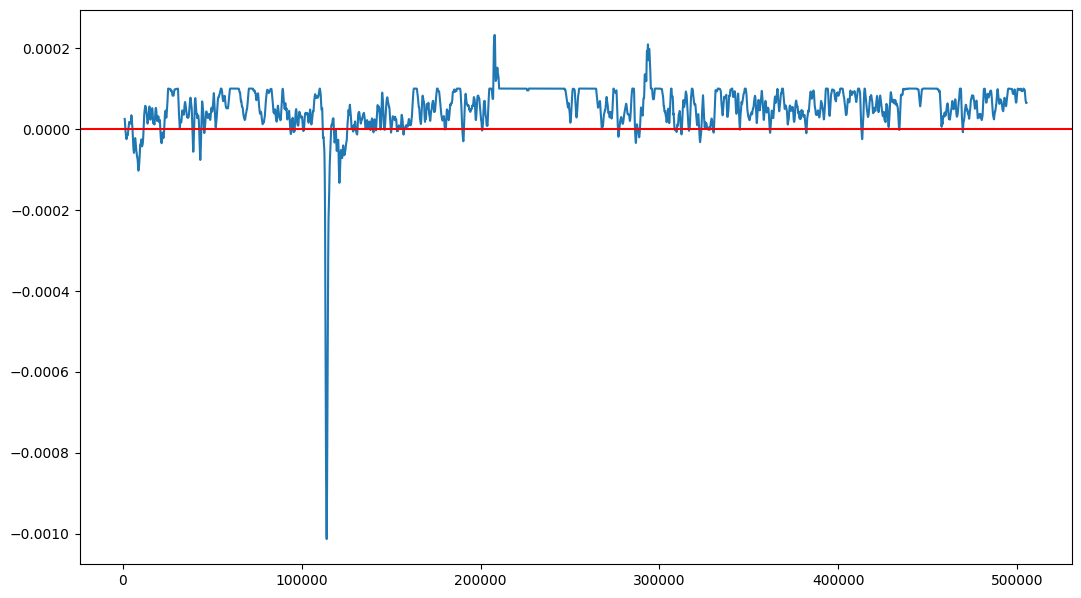

In [40]:
# plt.plot(df_total['funding_rate'])
plt.plot(df_total['funding_rate'].rolling(1000).mean())
plt.axhline(0, c = 'r')

In [41]:
df_total.head()

,timestamp,symbol_perp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left
0,1661248680,BTCUSDT,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120
1,1661248740,BTCUSDT,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060
2,1661248800,BTCUSDT,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000
3,1661248860,BTCUSDT,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940
4,1661248920,BTCUSDT,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880


## razmetka

### prep

In [91]:
def plot_selected_extremas(df, col, window=(0,400), color='red', figsize=(10,4)):
    plt.figure(figsize = figsize)
    plt.title(f"{col}:{window}")
    plt.plot(df.loc[window[0]:window[1], 'price'])
    plt.scatter(df.loc[window[0]:window[1]].loc[df['is_extrema'], 'index'], 
                df.loc[window[0]:window[1]].loc[df['is_extrema'], 'price'], 
                c='lime')
    plt.scatter(df.loc[window[0]:window[1]].loc[df[col], 'index'], 
                df.loc[window[0]:window[1]].loc[df[col], 'price'], 
                c=color)
    plt.show()
    plt.close()

$$profit = (1 - commision)^2 * (1 + leverage * \big|1 - \frac{Close}{Open}\big|)$$

In [92]:
min_prof = 1.0075
min_prof_3contracts = min_prof * 2 - 1

In [102]:
COMMISSION_RATE = 0.0008
LEVERAGE = 5

def get_balance_single(open_price, close_price, commision=COMMISSION_RATE, leverage=LEVERAGE):
    return (np.power(1 - commision, 2) *
            (1 + leverage * abs(1 - close_price/open_price)))

def get_balance(df, indices, commision=COMMISSION_RATE, leverage=LEVERAGE):
    prices = df.loc[indices, 'price']
    return np.prod([get_balance_single(start, end, commision, leverage) 
                    for start, end in zip(prices[:-1], prices[1:])])

### mark extremas

In [103]:
df_total['diff'] = df_total['open_perp'].diff(1)
df_total['diff_shift'] = df_total['diff'].shift(-1)
# if price didnt change from t-1, compare with t-2, t-3...
i = -1
print(i, (df_total['diff_shift'] == 0).sum())
while ((df_total['diff_shift'] == 0).sum()):
    i -= 1
    df_total.loc[df_total['diff_shift'] == 0,'diff_shift'] = \
            df_total['diff'].shift(i)[df_total['diff_shift'] == 0]
    print(i, (df_total['diff_shift'] == 0).sum())



df_total['is_extrema'] = (df_total['diff'] * df_total['diff_shift'] < 0)
df_total['ismaxima'] = (df_total['diff_shift'] < 0) & df_total['is_extrema']
df_total['isminima'] = (df_total['diff_shift'] >= 0) & df_total['is_extrema']

-1 13807
-2 2164
-3 652
-4 241
-5 107
-6 50
-7 23
-8 8
-9 2
-10 0


In [104]:
df_razmetka = df_total[['timestamp', 'open_perp', 'low_perp', 'high_perp', 'is_extrema', 'ismaxima', 'isminima']].copy()
df_razmetka.reset_index(inplace=True)
df_razmetka['price'] = np.where(
    df_razmetka['is_extrema'],
    np.where(
        df_razmetka['ismaxima'],
        df_razmetka['high_perp'],
        df_razmetka['low_perp']
    ),
    df_razmetka['open_perp']
)
df_razmetka.head()

,index,timestamp,open_perp,low_perp,high_perp,is_extrema,ismaxima,isminima,price
0,0,1661248680,21476.3,21451.0,21479.8,False,False,False,21476.3
1,1,1661248740,21459.7,21430.2,21459.7,False,False,False,21459.7
2,2,1661248800,21430.3,21414.1,21445.0,True,False,True,21414.1
3,3,1661248860,21445.0,21430.0,21446.8,True,True,False,21446.8
4,4,1661248920,21445.0,21430.0,21448.6,False,False,False,21445.0


### step1

In [105]:
df = df_razmetka.copy()

In [106]:
df.loc[df['is_extrema'], 'index'].loc[3:].iloc[:4]

3      3
5      5
6      6
10    10
Name: index, dtype: int64

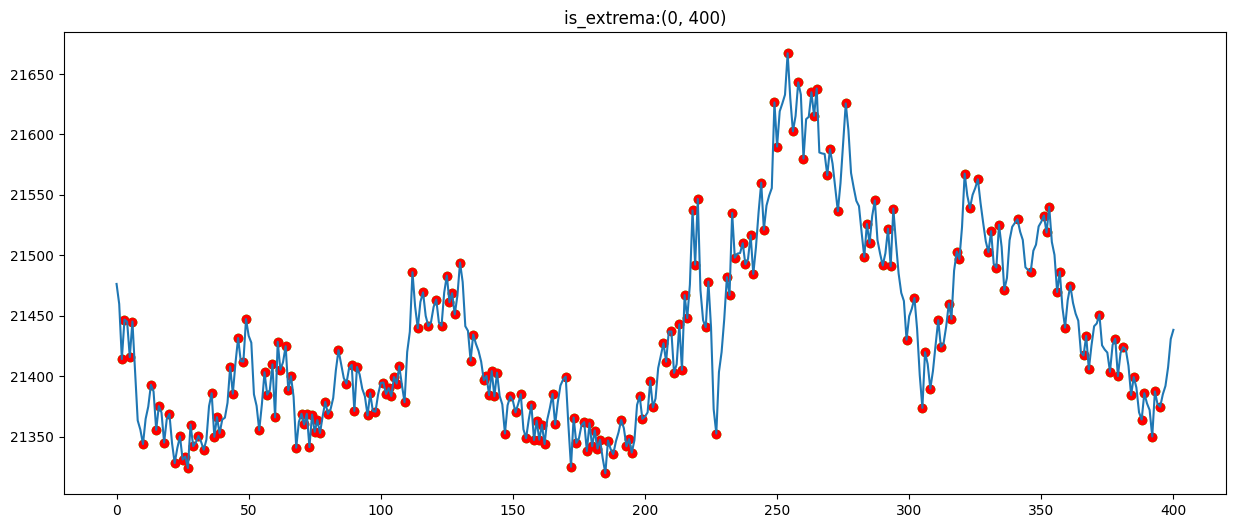

In [107]:
plot_selected_extremas(df_razmetka, 'is_extrema', figsize=(15,6))

In [108]:
#  skip first value because it wouldnt be an extrema
iterator = iter(df_razmetka.loc[df_razmetka['is_extrema'], 'index'].iloc[1:])
start = iterator.__next__()
df_razmetka['extr1'] = df_razmetka['is_extrema']
try:
    while True: 
        print(start)
        clear_output(wait=True)
        contracts = (iterator.__next__(), iterator.__next__(), iterator.__next__())
        balances = {
            'balance1' : get_balance(df_razmetka, [start, contracts[0]]),
            'balance123' : get_balance(df_razmetka, [start, contracts[0], contracts[1], contracts[2]]),
            'balance__3' : get_balance(df_razmetka, [start, contracts[2]])}
        
        max_possible_profit = max(balances.values())
        max_possible_combo = max(balances, key=balances.get)

        if((max_possible_profit > min_prof_3contracts) 
            & (max_possible_combo == 'balance123')):
                df_razmetka.loc[contracts[0], 'extr1'] = False
                iterator = iter(df_razmetka.index[df_razmetka['is_extrema'] & (df_razmetka.index>=contracts[0])])
                start = iterator.__next__()

        elif(max_possible_profit > min_prof):
            if (max_possible_combo == 'balance1'):
                df_razmetka.loc[contracts[1:], 'extr1'] = False
                start = contracts[0]

            elif (max_possible_combo == 'balance__3'):
                iterator = iter(df_razmetka.index[df_razmetka['is_extrema'] & (df_razmetka.index>=contracts[2])])
                
except StopIteration:
    pass

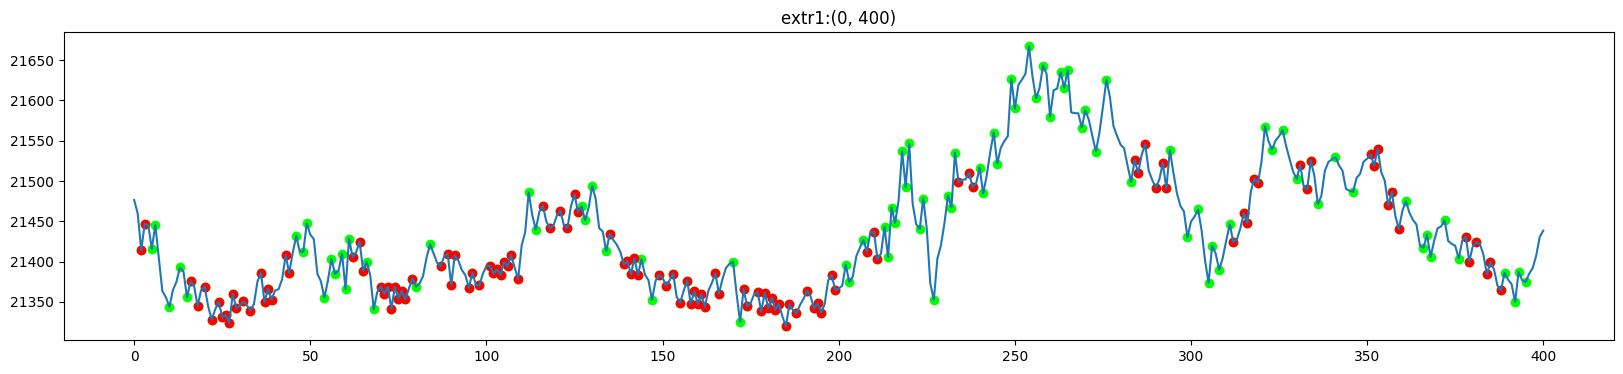

In [109]:
plot_selected_extremas(df_razmetka, 'extr1', figsize=(20,4))>>>

In [37]:
iterator = iter(df_razmetka.index[df_razmetka['is_extrema']])
#  skip first value because it wouldnt be an extrema
iterator.__next__()
# (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
(index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
extremas = [index_start]
try:
    while True: 
    # for i in range(1000):
        index_first_contract, price_first_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        index_second_contract, price_second_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        index_third_contract, price_third_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]

        balance1 = get_balance(balance, price_start, price_first_contract)
        balance12 = get_balance(balance1, price_first_contract, price_second_contract)
        balance123 = get_balance(balance12, price_second_contract, price_third_contract)
        balance__3 = get_balance(balance, price_start, price_third_contract)


        max_balance = max(balance1, balance123/min_prof_3contracts, balance__3)

        if (max_balance > balance * min_prof):
            if(max_balance == balance1):    
                extremas.append(index_first_contract)
                price_start = price_first_contract

            elif(max_balance == balance__3):
                iterator = iter(df_razmetka.index[df_razmetka['is_extrema'] & (df_razmetka.index>=index_third_contract)])

            elif(max_balance == balance123/min_prof_3contracts):
                # print(index_first_contract, end=' ')
                extremas.append(index_first_contract)
                iterator = iter(df_razmetka.index[df_razmetka['is_extrema'] & (df_razmetka.index>=index_first_contract)])
                (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
        else:
            pass
except StopIteration:
    pass

KeyError: '[21431.2] not in index'

In [29]:
# iterator = iter(df_razmetka.index[df_razmetka['is_extrema']])
# #  skip first value because it wouldnt be an extrema
# iterator.__next__()
# # (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
# (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
# extremas = [index_start]
# try:
#     while True: 
#     # for i in range(1000):
#         index_first_contract, price_first_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
#         index_second_contract, price_second_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
#         index_third_contract, price_third_contract = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]

#         balance1 = get_balance(balance, price_start, price_first_contract)
#         balance12 = get_balance(balance1, price_first_contract, price_second_contract)
#         balance123 = get_balance(balance12, price_second_contract, price_third_contract)
#         balance__3 = get_balance(balance, price_start, price_third_contract)


#         max_balance = max(balance1, balance123/min_prof_3contracts, balance__3)

#         if (max_balance > balance * min_prof):
#             if(max_balance == balance1):    
#                 extremas.append(index_first_contract)
#                 price_start = price_first_contract

#             elif(max_balance == balance__3):
#                 iterator = iter(df_razmetka.index[df_razmetka['is_extrema'] & (df_razmetka.index>=index_third_contract)])

#             elif(max_balance == balance123/min_prof_3contracts):
#                 # print(index_first_contract, end=' ')
#                 extremas.append(index_first_contract)
#                 iterator = iter(df_razmetka.index[df_razmetka['is_extrema'] & (df_razmetka.index>=index_first_contract)])
#                 (index_start, price_start) = df_razmetka.loc[iterator.__next__(), ['index', 'open_perp']]
#         else:
#             pass
# except StopIteration:
#     pass

# df_razmetka['extr1'] = np.where(df_razmetka.index.isin(extremas), True, False)

# print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
# print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")

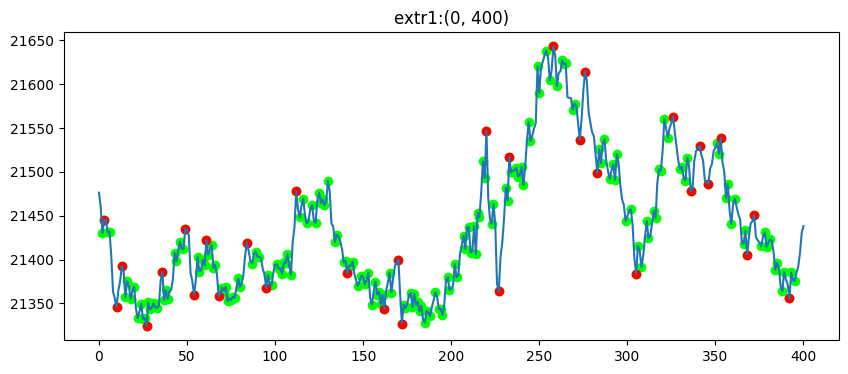

In [120]:
plot_selected_extremas(df_razmetka, 'extr1')

### step2

In [121]:
df_razmetka['extr2'] = df_razmetka['extr1'].copy()

all_extr = df_razmetka.loc[df_razmetka['is_extrema']].copy()
extr2 = df_razmetka.loc[df_razmetka['extr2']].reset_index(drop=True).copy()
non_extr2 = df_razmetka.loc[(~df_razmetka['extr2']) & df_razmetka['is_extrema']].copy()

extr2.head()

,index,timestamp,open_perp,is_extrema,ismaxima,isminima,extr1,extr2
0,3,1661248860,21445.0,True,True,False,True,True
1,10,1661249280,21345.8,True,False,True,True,True
2,13,1661249460,21392.7,True,True,False,True,True
3,27,1661250300,21324.0,True,False,True,True,True
4,36,1661250840,21385.8,True,True,False,True,True


In [122]:
start = 0
try:
    while True:
        left = extr2.loc[start, ['index', 'open_perp']]
        mid = extr2.loc[start+1, ['index', 'open_perp']]
        right = extr2.loc[start+2, ['index', 'open_perp']]
        
        extrema_range = all_extr.loc[left['index']:right['index']]

        if left['open_perp'] > mid['open_perp']:
            index_extrema = extrema_range['open_perp'].idxmin()
        elif left['open_perp'] < mid['open_perp']:
            index_extrema = extrema_range['open_perp'].idxmax()
        else:
            extr2.drop(extr2.index[extr2['index'] == mid['index']])
            continue

        extrema_range = all_extr.loc[left['index']:right['index']]
        if index_extrema == mid['index']:
            start += 1
            continue
        elif index_extrema == right['index']:
            extr2 = extr2.drop(start+1).reset_index(drop=True)
            continue
        else:
            # print(f"replace extrema {mid['index']} on {index_extrema}")
            extr2.loc[start+1] = extrema_range.loc[index_extrema]
            start += 1
            continue
except:
    pass

In [123]:
df_razmetka['extr2'] = np.where(df_razmetka.index.isin(extr2['index']), True, False)

In [124]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040


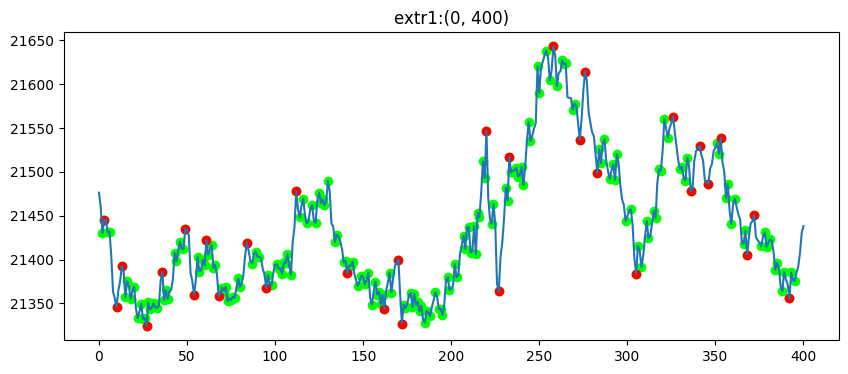

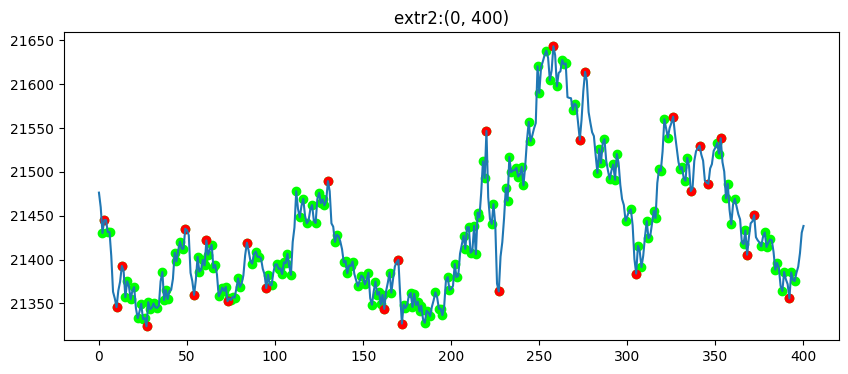

In [125]:
plot_selected_extremas(df_razmetka, 'extr1')
plot_selected_extremas(df_razmetka, 'extr2')

### step 3

In [35]:
(0,2,3,4)[[0]]

TypeError: tuple indices must be integers or slices, not list

In [209]:
def step3(df_raw, extr_col, new_extr_col):
    df = df_raw.copy()
    df[new_extr_col] = df[extr_col]
    left_index = 0
    while True:
        extremas_todrop = []
        for contracts in zip(
                                df.loc[df[new_extr_col], 'index'].loc[left_index:].iloc[:-3], 
                                df.loc[df[new_extr_col], 'index'].loc[left_index:].shift(-1).iloc[:-3], 
                                df.loc[df[new_extr_col], 'index'].loc[left_index:].shift(-2).iloc[:-3], 
                                df.loc[df[new_extr_col], 'index'].loc[left_index:].shift(-3).iloc[:-3]):
            
            balance1 = get_balance([contracts[0], contracts[3]])
            balance3 = get_balance(contracts)
            if (balance1 * min_prof_3contracts >= balance3 * min_prof):
                clear_output(wait=True)
                print([contract1, contract2])
                extremas_todrop += [contract1, contract2]
                df.loc[[contract1, contract2], new_extr_col] = False
                left_index = contract3
                break
        if(len(extremas_todrop) == 0):
            return df


In [210]:
df_razmetka.head()

,Unnamed: 0,index,timestamp,open_perp,is_extrema,ismaxima,isminima,extr1,extr2,extr3,extr4,extr5,extr6,extr7
0,0,0,1661248680,21476.3,False,False,False,False,False,False,False,False,False,False
1,1,1,1661248740,21459.7,False,False,False,False,False,False,False,False,False,False
2,2,2,1661248800,21430.3,True,False,True,False,False,False,False,False,False,False
3,3,3,1661248860,21445.0,True,True,False,True,True,True,True,True,True,True
4,4,4,1661248920,21445.0,False,False,False,False,False,False,False,False,False,False


In [212]:
temp = step3(df_razmetka, 'is_extrema', 'test_extrema')

[15500.0, 15501.0]


KeyboardInterrupt: 

In [129]:
df_razmetka = step3(df_razmetka, 'extr2', 'extr3')

[381303.0, 381307.0]


In [130]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")
print(f"extremas after step3: {df_razmetka['extr3'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040
extremas after step3: 15,096


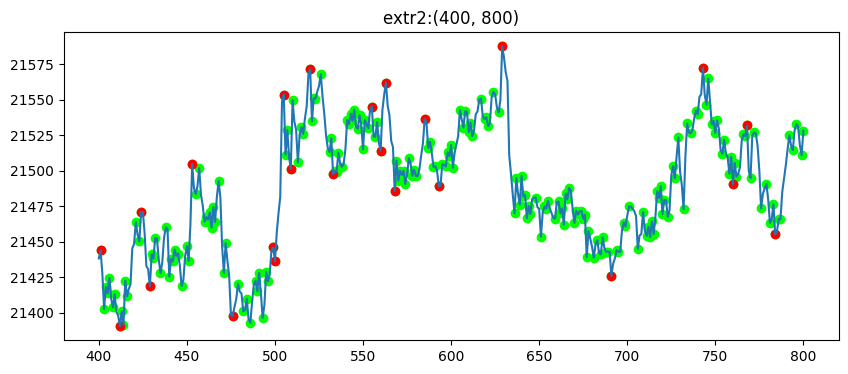

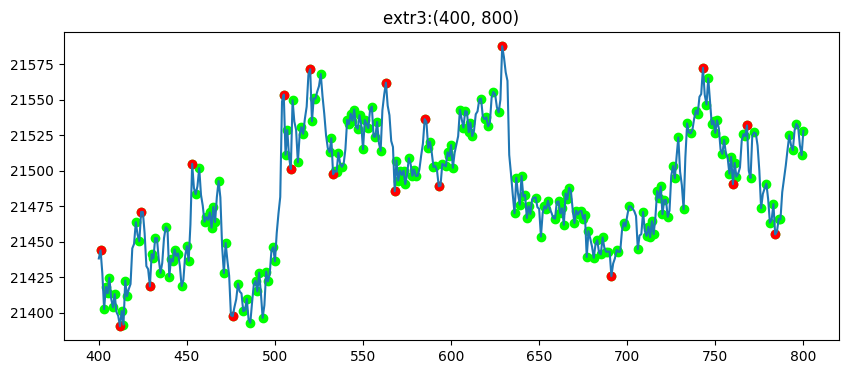

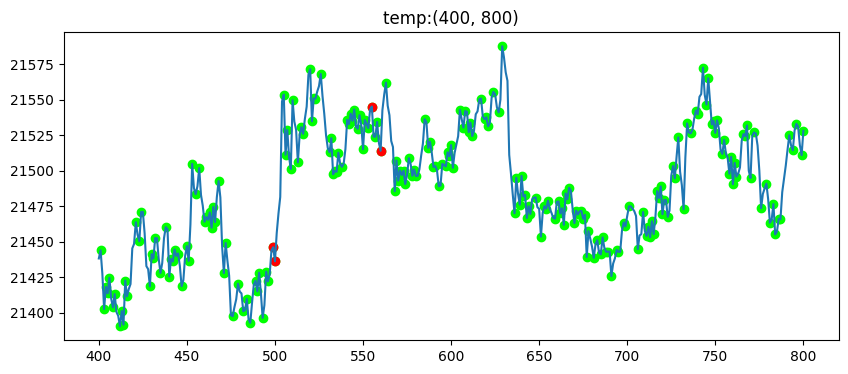

In [136]:
plot_selected_extremas(df_razmetka, 'extr2', window=(400,800))
plot_selected_extremas(df_razmetka, 'extr3', window=(400,800))

df_razmetka['temp'] = ~df_razmetka['extr3'] & df_razmetka['extr2']
plot_selected_extremas(df_razmetka, 'temp', window=(400,800))
df_razmetka.drop(columns='temp', inplace=True)

### step 4

In [137]:
def price(idx):
    return df_razmetka.loc[idx, 'open_perp']

def step4(df_raw, extr_col, new_extr_col):
    df = df_raw.copy()
    df[new_extr_col] = df[extr_col]
    while(True):
        new_extremas = []
        for start, end in tqdm(zip(df.loc[df[new_extr_col], 'index'].iloc[:-1], df.loc[df[new_extr_col], 'index'].shift(-1))):

            order_short_long = (('isminima', 'ismaxima') if (price(start) > price(end)) else ('ismaxima', 'isminima'))
            profitable_combos = {}
            for first_contract in df.loc[start+1:end-1].loc[df[order_short_long[0]]].index:
                for second_contract in df.loc[first_contract+1:end-1].loc[df[order_short_long[1]]].index:
                    extr2_balance = get_balance(1, 
                                                price(start), 
                                                price(end))
                    extr3_balance = get_balance_3contracts(1, 
                                                price(start),
                                                price(first_contract),
                                                price(second_contract),
                                                price(end))
                    
                    if(extr3_balance > extr2_balance * min_prof_3contracts):
                        profitable_combos.update({(first_contract, second_contract) : extr3_balance})
            if(len(profitable_combos) > 0):
                new_extremas.append(max(profitable_combos, key=profitable_combos.get))
        print(f"extremas before: {df[new_extr_col].sum()}")
        df.loc[pd.Series(new_extremas).explode().values, new_extr_col] = True
        print(f"extremas after: {df[new_extr_col].sum()}")
        
        if (len(new_extremas) == 0):
            return df

In [138]:
df_razmetka.head()

,index,timestamp,open_perp,is_extrema,ismaxima,isminima,extr1,extr2,extr3
0,0,1661248680,21476.3,False,False,False,False,False,False
1,1,1661248740,21459.7,False,False,False,False,False,False
2,2,1661248800,21430.3,True,False,True,False,False,False
3,3,1661248860,21445.0,True,True,False,True,True,True
4,4,1661248920,21445.0,False,False,False,False,False,False


In [139]:
df_razmetka = step4(df_razmetka, 'extr3', 'extr4')

6264it [00:42, 145.98it/s] 


KeyboardInterrupt: 

In [ ]:
# df_razmetka.to_csv('razmetkas/after_step4.csv')

In [ ]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")
print(f"extremas after step3: {df_razmetka['extr3'].sum():,}")
print(f"extremas after step4: {df_razmetka['extr4'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040
extremas after step3: 15,096
extremas after step4: 18,484


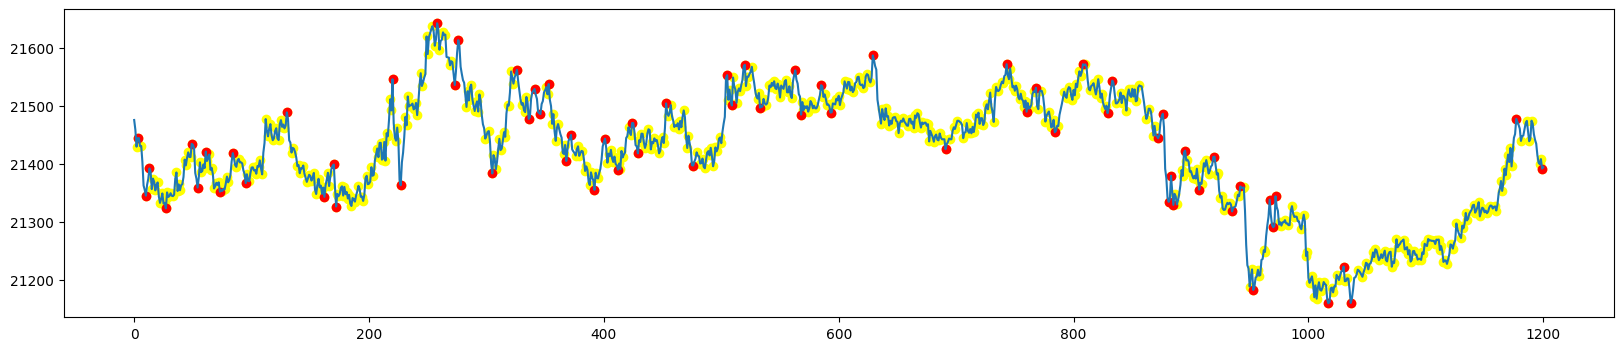

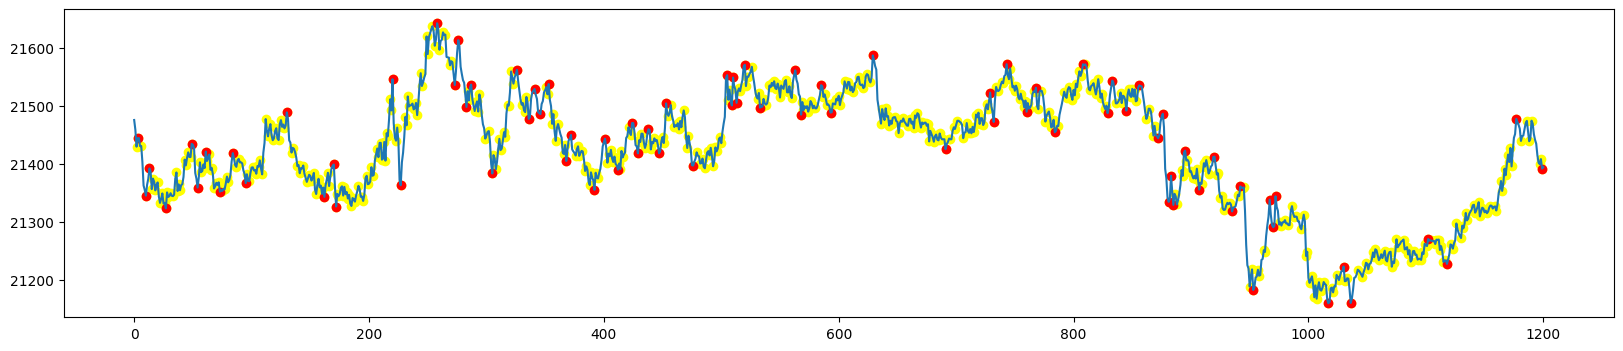

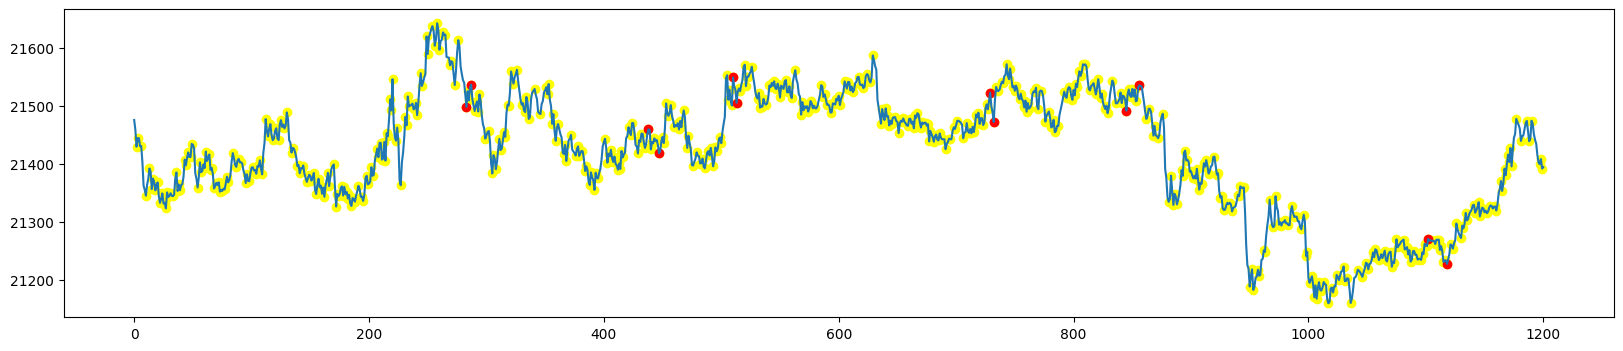

In [ ]:
plot_selected_extremas(df_razmetka, 'extr3', window=(400,800))
plot_selected_extremas(df_razmetka, 'extr4', window=(400,800))

df_razmetka['temp'] = ~df_razmetka['extr3'] & df_razmetka['extr4']
plot_selected_extremas(df_razmetka, 'temp', window=(400,800))
df_razmetka.drop(columns='temp', inplace=True)

### repeat steps 3, 4 until number of extremas don't change

In [ ]:
df_razmetka = step3(df_razmetka, 'extr4', 'extr5')
df_razmetka = step4(df_razmetka, 'extr5', 'extr6')
df_razmetka = step3(df_razmetka, 'extr6', 'extr7')

[375263.0, 375265.0]


18377it [01:55, 158.87it/s]


extremas before: 18378
extremas after: 18400


18399it [01:54, 160.50it/s]
c:\Coding\Anaconda\envs\diploma_binance\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


extremas before: 18400
extremas after: 18400


In [ ]:
print(f"total extremas: {df_razmetka['is_extrema'].sum():>12,}")
print(f"extremas after step1: {df_razmetka['extr1'].sum():,}")
print(f"extremas after step2: {df_razmetka['extr2'].sum():,}")
print(f"extremas after step3: {df_razmetka['extr3'].sum():,}")
print(f"extremas after step4: {df_razmetka['extr4'].sum():,}")
print(f"extremas after step5: {df_razmetka['extr5'].sum():,}")
print(f"extremas after step6: {df_razmetka['extr6'].sum():,}")
print(f"extremas after step7: {df_razmetka['extr7'].sum():,}")

total extremas:      188,275
extremas after step1: 18,637
extremas after step2: 16,040
extremas after step3: 15,096
extremas after step4: 18,484
extremas after step5: 18,378
extremas after step6: 18,400
extremas after step7: 18,400


In [ ]:
# df_razmetka.to_csv('razmetkas/after_step7.csv')

In [140]:
df_razmetka = pd.read_csv('razmetkas/after_step7.csv')

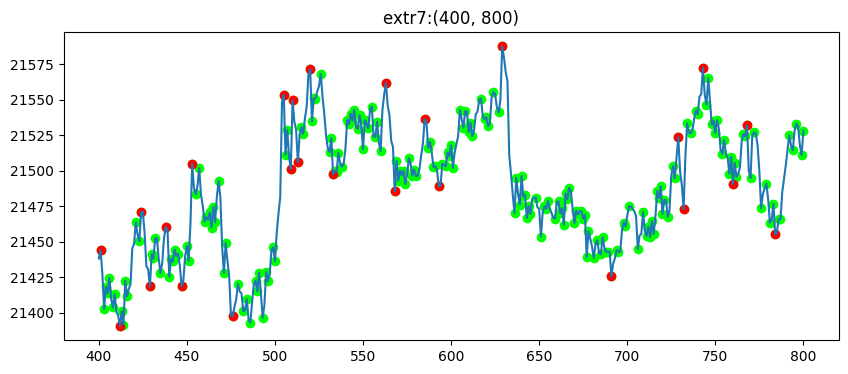

In [143]:
plot_selected_extremas(df_razmetka, 'extr7', (400,800))

## Initial model

### final df prep

In [ ]:
df_total.to_csv('data/df_total.csv')
df_razmetka.to_csv('data/df_razmetka.csv')

df_total = pd.read_csv('data/df_total.csv', index_col=[0])
df_razmetka = pd.read_csv('data/df_razmetka.csv', index_col=[0])

In [ ]:
df_fin = df_total.copy()
df_fin['extr2'] = df_razmetka['extr2']
df_fin.drop(columns=['symbol_perp', 'diff', 'diff_shift', 'is_extrema'], inplace=True)

In [ ]:
df_fin.head()

,timestamp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left,ismaxima,isminima,extr2
0,1661248680,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120,False,False,False
1,1661248740,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060,False,False,False
2,1661248800,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000,False,True,False
3,1661248860,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940,True,False,True
4,1661248920,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880,False,False,False


Lets imagine our range of opening contract lays between 

(high + max(open, close))/2

and

(low + min(open, close))/2

In [ ]:
df_fin['low_border'] = (df_fin['low_perp'] + df_fin[['open_perp', 'close_perp']].min(axis=1)) / 2
df_fin['up_border'] = (df_fin['high_perp'] + df_fin[['open_perp', 'close_perp']].max(axis=1)) / 2

In [ ]:
df_fin.head()

,timestamp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left,ismaxima,isminima,extr2,low_border,up_border
0,1661248680,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120,False,False,False,21455.3,21478.05
1,1661248740,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060,False,False,False,21430.2,21459.70
2,1661248800,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000,False,True,False,21422.2,21445.00
3,1661248860,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940,True,False,True,21437.5,21445.90
4,1661248920,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880,False,False,False,21430.6,21446.80


In [ ]:
df_fin.loc[df_fin['extr2'] & df_fin['ismaxima'], 'target'] = df_fin.loc[df_fin['extr2'] & df_fin['ismaxima'], 'up_border']
df_fin.loc[df_fin['extr2'] & df_fin['isminima'], 'target'] = df_fin.loc[df_fin['extr2'] & df_fin['isminima'], 'low_border']

In [ ]:
df_fin = df_fin.fillna(method='bfill').dropna()

In [ ]:
df_fin.head()

,timestamp,open_perp,close_perp,low_perp,high_perp,volume_perp,trades_perp,symbol_cq,open_cq,close_cq,low_cq,high_cq,volume_cq,trades_cq,bidPrice_perp,bidQty_perp,askPrice_perp,askQty_perp,funding_rate,bidPrice_cq,bidQty_cq,askPrice_cq,askQty_cq,time_left,ismaxima,isminima,extr2,low_border,up_border,target
0,1661248680,21476.3,21459.6,21451.0,21479.8,413.330,3596,BTCUSDT_220930,21511.1,21483.9,21483.9,21511.1,1.659,22,21476.2,8.013,21476.3,6.975,0.000011,21502.4,0.019,21508.0,0.071,3276120,False,False,False,21455.3,21478.05,21445.9
1,1661248740,21459.7,21430.2,21430.2,21459.7,378.801,3206,BTCUSDT_220930,21493.2,21453.5,21453.5,21493.2,0.579,40,21459.1,3.420,21459.2,14.399,0.000012,21487.4,0.019,21493.3,0.050,3276060,False,False,False,21430.2,21459.70,21445.9
2,1661248800,21430.3,21445.0,21414.1,21445.0,619.156,5519,BTCUSDT_220930,21459.9,21478.3,21440.6,21478.4,1.392,46,21432.6,0.820,21434.3,0.004,0.000012,21456.4,0.169,21462.8,0.071,3276000,False,True,False,21422.2,21445.00,21445.9
3,1661248860,21445.0,21445.0,21430.0,21446.8,311.295,3116,BTCUSDT_220930,21476.7,21470.2,21460.0,21476.7,1.419,41,21444.9,25.023,21445.0,1.005,0.000011,21476.7,0.100,21478.3,0.054,3275940,True,False,True,21437.5,21445.90,21445.9
4,1661248920,21445.0,21431.2,21430.0,21448.6,250.049,2848,BTCUSDT_220930,21479.4,21463.8,21460.4,21479.5,0.400,24,21444.9,17.361,21445.0,1.806,0.000010,21471.6,0.019,21476.5,0.121,3275880,False,False,False,21430.6,21446.80,21344.8


In [ ]:
X = df_fin.drop(columns= ['timestamp', 'symbol_cq', 'ismaxima', 'isminima', 'extr2', 'low_border', 'up_border', 'target'])
y = df_fin['target']

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y.values.reshape(-1,1))

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
X_scaled
y_scaled

## Simple Keras LSTM model

## Archive

In [ ]:
# # for left, mid, right in zip(new_extremas[:-2], new_extremas[1:-1], new_extremas[2:]):
# non_extremas = pd.Series(list(set(df_total.index[df_total['is_extrema']]) - set(extremas) - set([2])))
# non_extremas.head()

# new_extremas = extremas.copy()
# start = 0
# while True:
#     new_extremas.reset_index(inplace=True, drop=True)
#     # print(new_extremas.head())
#     left, mid, right = new_extremas.index[start], new_extremas.index[start+1], new_extremas.index[start+2]
#     print(f"{start} - {new_extremas[left]:>3} ({df_total.loc[left, 'open_perp']}) {new_extremas[mid]} ({df_total.loc[mid, 'open_perp']}) {new_extremas[right]} ({df_total.loc[right, 'open_perp']})", end = '   ')
#     points_inbetween = non_extremas[(non_extremas > left) & (non_extremas < right)]
#     all_points = pd.concat([points_inbetween, pd.Series([left, mid, right])])
#     if (df_total.loc[new_extremas[left], 'open_perp'] > df_total.loc[new_extremas[mid], 'open_perp']):
#         print('min')
#         new_minima = df_total.loc[all_points, 'open_perp'].idxmin()
#         if new_minima == new_extremas[mid]:
#             start += 1
#             continue
#         elif new_minima == new_extremas[right]:
#             new_extremas.pop(new_extremas[start+1])
#             continue
#         else:
#             new_extremas[start+1] = new_minima
#             start += 1
#             continue
#     elif (df_total.loc[new_extremas[left], 'open_perp'] < df_total.loc[new_extremas[mid], 'open_perp']):
#         print('max')
#         new_maxima = df_total.loc[all_points, 'open_perp'].idxmax()
#         if new_maxima == new_extremas[mid]:
#             start += 1
#             continue
#         elif new_maxima == new_extremas[right]:
#             new_extremas.pop(new_extremas[start+1])
#             continue
#         else:
#             new_extremas[start+1] = new_maxima
#             start += 1
#             continue
#     else:
#         print('drop')
#         new_extremas.pop(new_extremas.index[mid])
#         continue
    
        